<a href="https://colab.research.google.com/github/ayushpatelid01/stock-prediction/blob/main/Stock_Prediction_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense
from sklearn.preprocessing import MinMaxScaler

In [2]:
df = pd.read_csv("/content/NSE-Tata-Global-Beverages-Limited.csv")
df.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2018-10-08,208.00,222.25,206.85,216.00,215.15,4642146.0,10062.83
1,2018-10-05,217.00,218.60,205.90,210.25,209.20,3519515.0,7407.06
2,2018-10-04,223.50,227.80,216.15,217.25,218.20,1728786.0,3815.79
3,2018-10-03,230.00,237.50,225.75,226.45,227.60,1708590.0,3960.27
4,2018-10-01,234.55,234.60,221.05,230.30,230.90,1534749.0,3486.05


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1235 entries, 0 to 1234
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Date                  1235 non-null   object 
 1   Open                  1235 non-null   float64
 2   High                  1235 non-null   float64
 3   Low                   1235 non-null   float64
 4   Last                  1235 non-null   float64
 5   Close                 1235 non-null   float64
 6   Total Trade Quantity  1235 non-null   float64
 7   Turnover (Lacs)       1235 non-null   float64
dtypes: float64(7), object(1)
memory usage: 77.3+ KB


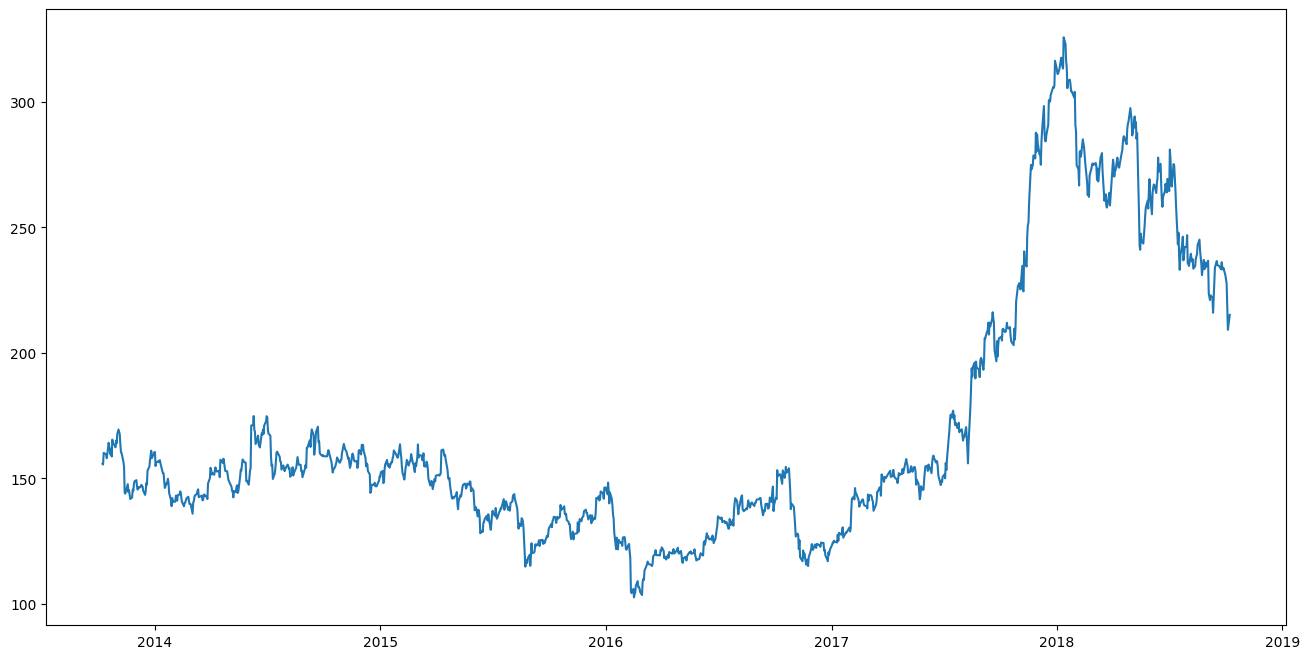

In [4]:
df["Date"] = pd.to_datetime(df.Date, format = "%Y-%m-%d")
df.index = df['Date']

plt.figure(figsize=(16,8))
plt.plot(df["Close"], label = "Close Price History")

In [6]:
data = df.sort_index(ascending=True, axis=0)
new_dataset = pd.DataFrame(index=range(0,len(df)), columns=['Date', 'Close'])

new_dataset = data[['Date', 'Close']].reset_index(drop=True)
new_dataset.head()

,Date,Close
0,2013-10-08,155.80
1,2013-10-09,155.55
2,2013-10-10,160.15
3,2013-10-11,160.05
4,2013-10-14,159.45


In [7]:
new_dataset.describe()

,Date,Close
count,1235,1235.000000
mean,2016-04-08 15:39:47.368421120,168.731053
min,2013-10-08 00:00:00,102.650000
25%,2015-01-10 12:00:00,137.225000
50%,2016-04-11 00:00:00,151.100000
75%,2017-07-10 12:00:00,169.500000
max,2018-10-08 00:00:00,325.750000
std,NaN,51.544928


In [8]:
new_dataset.index = new_dataset['Date']
new_dataset.drop('Date', axis=1, inplace=True)

# Split before scaling to prevent data leakage
train_data = new_dataset[:987]
valid_data = new_dataset[987:]

# Scale only on Train data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_train_data = scaler.fit_transform(train_data)

x_train_data, y_train_data = [], []

for i in range(60, len(train_data)):
  x_train_data.append(scaled_train_data[i-60:i, 0])
  y_train_data.append(scaled_train_data[i, 0])

x_train_data, y_train_data = np.array(x_train_data), np.array(y_train_data)
x_train_data = np.reshape(x_train_data, (x_train_data.shape[0], x_train_data.shape[1], 1))

In [9]:
lstm_model = Sequential()
lstm_model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train_data.shape[1],1)))
lstm_model.add(LSTM(units=150))
lstm_model.add(Dense(1))

inputs_data = new_dataset[len(new_dataset) - len(valid_data) - 60:].values
inputs_data = inputs_data.reshape(-1,1)
inputs_data = scaler.transform(inputs_data)

lstm_model.compile(loss='mean_squared_error', optimizer='adam')
lstm_model.fit(x_train_data, y_train_data, epochs=5, batch_size=2, verbose=2)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Epoch 1/5
464/464 - 36s - 79ms/step - loss: 0.0053
Epoch 2/5
464/464 - 40s - 86ms/step - loss: 0.0019
Epoch 3/5
464/464 - 29s - 63ms/step - loss: 0.0015
Epoch 4/5
464/464 - 42s - 90ms/step - loss: 0.0012
Epoch 5/5
464/464 - 41s - 88ms/step - loss: 0.0011


In [10]:
X_test = []
for i in range(60, inputs_data.shape[0]):
  X_test.append(inputs_data[i-60:i, 0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
closing_price = lstm_model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step


In [11]:
lstm_model.save("saved_model.h5")

/tmp/ipython-input-12-3820846766.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_data['Predictions'] = closing_price


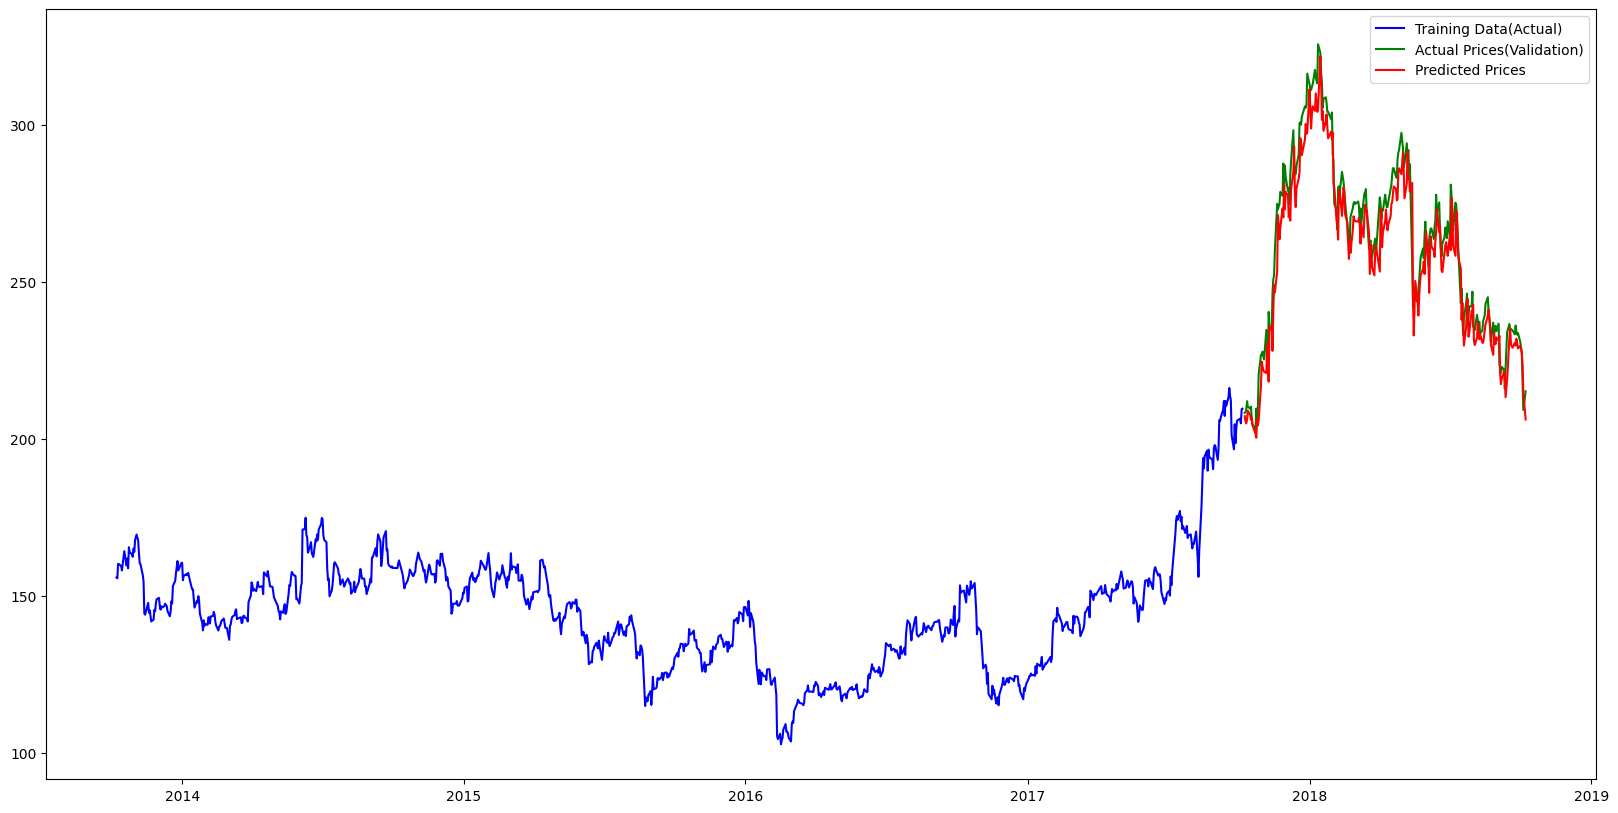

In [12]:
train_data = new_dataset[:987]
valid_data = new_dataset[987:]
valid_data['Predictions'] = closing_price
plt.plot(train_data["Close"], label="Training Data(Actual)", color='blue')
plt.plot(valid_data["Close"], label="Actual Prices(Validation)", color='green')
plt.plot(valid_data["Predictions"], label="Predicted Prices", color='red')
plt.legend()